# Stance Detection Using Bidirectional Long Short-Term Memory Followed By Convolutional Neural Network

`Convolutional Neural Networks` `Bidirectional Long Short-Term Memory`  
`AraVec Word Vectors`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language` `Transfer Learning`

---

In this notebook, we rely on a hybrid architecture comprising a very simple bidirectional long short-term memory followed by a convolutional neural network to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The pretrained vectors (AraVec project) was introduced in the paper:
```
AraVec: A set of Arabic Word Embedding Models for use in Arabic NLP.
```

## Packages

In [ ]:
!pip install gensim
!pip install pyarabic

In [ ]:
import gensim
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from preprocessing import *
from utils import AraStanceData, evaluate, stance_to_int

## Raw data

- Download the raw data:



In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

- Let's start by reading the raw data:

In [ ]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_val = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_val.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [ ]:
instance_no = 90
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: شخص بيلعب باليه في شارع التجمع الخامس
Article text: "هل يحبني"؟ سؤال تطرحه المرأة على نفسها مع بداية ميلاد مشاعر إعجاب بشخص ما، وبوادر نشوء علاقة. لكن أحيانا يحتاج الرجل لوقت طويل ليظهر مشاعره الحقيقية بوضوح، فما هي العلامات التي تدلك على أنه لا يستحقك أو أنه يحبك بالفعل؟ تردد الرجل في إظهار مشاعره تجاه المرأة، مسألة محيرة جدا للمرأة. وقد يكون هذا التردد مؤشرا على التأني في المشاعر أو عدم وجود مشاعر حقيقية من الأساس، فكيف تحدد المرأة هذا الأمر. ثمة بعض العلامات التي تؤكد أن هذا الرجل لا يستحق أن تنتظريه، ومن بينها: دائم الانتقاد: الرجل الذي لا يكف عن انتقاد مظهرك وقوامك وملابسك، لا يحبك بالتأكيد. فالقاعدة الأساسية هي أن الرجل عندما يحبك فهو يحب حتى عيوبك. يهتم بنفسه فقط: الرجل الذي لا يبذل أي مجهود في محاولة مقابلتك، وعندما يقابلك بالصدفة يحدد بحسب وقته ورغباته، المكان الذي تتقابلان فيه وموضوعات الحوار، هو بالتأكيد لم يصل لمرحلة كافية من الاهتمام بك، وفقا للنقاط التي رصدها موقع "غوفيمنين" الألماني. لا يرغب في معرفة عائلتك وأصدقائك: عندما لا يهتم الرجل بالتعرف على عائلتك وأص

- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Embedding layer

- We will use AraVec pretrained word vectors to represent the input.

### Preprocessing

- To increase the hit rate between the words in our raw data and the tokens (i.e. the keys in AraVec dictionary) in AraVec dictionary, we need to preprocess the data in a way similar to the preprocessing performed to produce those tokens.

- Let's use the following function to preprocess the training, validation, and testing data:

In [ ]:
# this function is resposible for the preprocessing routine
def preprocess(instances):
  instances = list(map(remove_puncuation, instances))
  instances = list(map(remove_diacritics, instances))
  instances = list(map(remove_longation, instances))
  instances = list(map(remove_unicode_codes, instances))
  instances = list(map(process_numerals, instances))
  instances = list(map(normalize, instances))
  instances = list(map(remove_extra_spaces, instances))
  return instances

- Before preprocessing each claim article pair, we need to concatenate them.

In [ ]:
# preprocess training data
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]
preprocessed_train_instances = preprocess(train_instances)

# preprocess validation data
val_instances = [raw_val.claims[raw_val.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_val.articles)]
preprocessed_val_instances = preprocess(val_instances)

# preprocess testing data
test_instances = [raw_test.claims[raw_test.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_test.articles)]
preprocessed_test_instances = preprocess(test_instances)

- Let's see a preprocessed instance:

In [ ]:
instance_no = 90
print(f"Claim Article text: {preprocessed_train_instances[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim Article text: شخص بيلعب باليه في شارع التجمع الخامس هل يحبني ؟ سؤال تطرحه المراه علي نفسها مع بدايه ميلاد مشاعر اعجاب بشخص ما وبوادر نشوء علاقه لكن احيانا يحتاج الرجل لوقت طويل ليظهر مشاعره الحقيقيه بوضوح فما هي العلامات التي تدلك علي انه لا يستحقك او انه يحبك بالفعل ؟ تردد الرجل في اظهار مشاعره تجاه المراه مساله محيره جدا للمراه وقد يكون هذا التردد مؤشرا علي التاني في المشاعر او عدم وجود مشاعر حقيقيه من الاساس فكيف تحدد المراه هذا الامر ثمه بعض العلامات التي تؤكد ان هذا الرجل لا يستحق ان تنتظريه ومن بينها دائم الانتقاد الرجل الذي لا يكف عن انتقاد مظهرك وقوامك وملابسك لا يحبك بالتاكيد فالقاعده الاساسيه هي ان الرجل عندما يحبك فهو يحب حتي عيوبك يهتم بنفسه فقط الرجل الذي لا يبذل اي مجهود في محاوله مقابلتك وعندما يقابلك بالصدفه يحدد بحسب وقته ورغباته المكان الذي تتقابلان فيه وموضوعات الحوار هو بالتاكيد لم يصل لمرحله كافيه من الاهتمام بك وفقا للنقاط التي رصدها موقع غوفيمنين الالماني لا يرغب في معرفه عائلتك واصدقائك عندما لا يهتم الرجل بالتعرف علي عائلتك واصدقائك المقربين فهذا دليل علي

### Initialization

- Download the pretrained vectors first:

In [ ]:
!wget "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_300_wiki.zip"
!unzip "full_uni_cbow_300_wiki.zip"

- Load the pretrained vectors:

In [ ]:
embedding_model = gensim.models.Word2Vec.load("full_uni_cbow_300_wiki.mdl")
print("AraVect project contains",len(embedding_model.wv.index_to_key),"tokens")

AraVect project contains 320636 tokens


- We need to decide on the words we are going to use in the final representation of each instance, so we will use a vectorization layer to learn a vocabulary from our training data. We allowed 30K tokens in our vocabulary.
- We also going to need a word index, which maps words to indices like `{word1-->idx1, word2-->idx2, ...}`. The indices will be used to store the vector representation of each word in the embedding matrix.

In [ ]:
# Option 1 using TextVectorization layer
# max_tokens represents the maximum size of the vocabulary
vectorizer = tf.keras.layers.TextVectorization(max_tokens=20000, output_sequence_length=150, standardize=None)
text_ds = tf.data.Dataset.from_tensor_slices(preprocessed_train_instances).batch(128)

# learn the vocabulary based on the training data
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Option 2 using NLTK tokenizer
# import nltk
# from nltk import  word_tokenize
# nltk.download('punkt')

# def tokenization(text):
#   return word_tokenize(text)

# train_tokenized = list(map(tokenization, train_samples))
# tokens = [token for sublist in train_tokenized for token in sublist]
# tokens = set(tokens)
# word_index = dict(zip(tokens, range(len(tokens))))
# len(tokens)

- We are now ready to create an embedding matrix which maps token indices of our vocabulary to pretrained word vectors from AraVec project:

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  if embedding_model.wv.__contains__(word):
    embedding_matrix[i] = embedding_model.wv.get_vector(word)
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 19860 words (140 misses)


- Let's see the representation of a random token:

In [ ]:
print(f"The word 'يناير' is at index {word_index['يناير']}")
print(f"The vector representation of 'يناير' is {embedding_matrix[word_index['يناير']]}")

The word 'يناير' is at index 370
The vector representation of 'يناير' is [ 0.51005375  1.19242501 -1.1961081   1.54170382  0.83659106  0.98661953
  2.35651946  1.40938616  0.46756575 -1.15503812 -2.05074883  1.79200149
  2.26149178 -2.35674977 -1.54589176  1.4476347   0.17506057 -1.03495252
  0.14923877  0.50402081 -1.22456503 -2.81537771 -0.14951073 -0.64106113
 -1.78856778 -3.01331806  1.09811449  0.82774377 -2.12052202  0.10627326
 -0.3470996   0.56881094  0.70859134  1.14366102 -1.39147961 -0.93328577
 -0.41829142  0.35251924 -5.5062871  -0.01710663  1.58901513 -1.04543102
 -1.53454065 -0.88687831 -0.14384538  1.67812455  0.39177114 -1.44210482
  1.21285033  0.28208566 -0.27708358  1.30340207 -0.0260686   1.36871862
  0.28364053  2.31196856 -1.6904012  -1.23371506 -0.75107098  1.8761574
 -0.73244673 -0.20883329 -0.66077822  1.06395638 -1.04924607  0.86401767
 -1.4296838  -0.46038389  1.66213858  2.74791789  2.06197238  1.3414613
 -1.38134551 -1.60160661 -2.83723998  1.29322004 -1.6

- Let's initialize our embedding layer with the embedding matrix:

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Datasets

In [ ]:
batch_size = 128

- Before creating the dataset, we need to vectorize the training, validation, and testing data using the adapted vectorizer. This means replace every word in an instance by its index in the word index:

In [ ]:
x_train = vectorizer(np.array([[s] for s in preprocessed_train_instances])).numpy()
x_val = vectorizer(np.array([[s] for s in preprocessed_val_instances])).numpy()
x_test = vectorizer(np.array([[s] for s in preprocessed_test_instances])).numpy()

- Let's see a vectorized instance:

In [ ]:
instance_no = 90
print(f"Original preprocessed instance: {preprocessed_train_instances[instance_no]}")
print(f"Vectorized instance: {x_train[instance_no]}")

Original preprocessed instance: شخص بيلعب باليه في شارع التجمع الخامس هل يحبني ؟ سؤال تطرحه المراه علي نفسها مع بدايه ميلاد مشاعر اعجاب بشخص ما وبوادر نشوء علاقه لكن احيانا يحتاج الرجل لوقت طويل ليظهر مشاعره الحقيقيه بوضوح فما هي العلامات التي تدلك علي انه لا يستحقك او انه يحبك بالفعل ؟ تردد الرجل في اظهار مشاعره تجاه المراه مساله محيره جدا للمراه وقد يكون هذا التردد مؤشرا علي التاني في المشاعر او عدم وجود مشاعر حقيقيه من الاساس فكيف تحدد المراه هذا الامر ثمه بعض العلامات التي تؤكد ان هذا الرجل لا يستحق ان تنتظريه ومن بينها دائم الانتقاد الرجل الذي لا يكف عن انتقاد مظهرك وقوامك وملابسك لا يحبك بالتاكيد فالقاعده الاساسيه هي ان الرجل عندما يحبك فهو يحب حتي عيوبك يهتم بنفسه فقط الرجل الذي لا يبذل اي مجهود في محاوله مقابلتك وعندما يقابلك بالصدفه يحدد بحسب وقته ورغباته المكان الذي تتقابلان فيه وموضوعات الحوار هو بالتاكيد لم يصل لمرحله كافيه من الاهتمام بك وفقا للنقاط التي رصدها موقع غوفيمنين الالماني لا يرغب في معرفه عائلتك واصدقائك عندما لا يهتم الرجل بالتعرف علي عائلتك واصدقائك المقربين ف

- Let's initialize the datasets we are going to use for the training and testing:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_labels = [stance_to_int[s] for s in raw_val.stances]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## Model

- Now the datasets are ready, we can work on the model:

In [ ]:
def create_model(lr):
  int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
  embedded_sequences = embedding_layer(int_sequences_input)

  lstm_output_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embedded_sequences)
  lstm_output_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(lstm_output_1)

  conv1 = tf.keras.layers.Conv1D(50, 2, activation="relu", use_bias=True)(lstm_output_2)
  conv2 = tf.keras.layers.Conv1D(50, 3, activation="relu", use_bias=True)(lstm_output_2)
  conv3 = tf.keras.layers.Conv1D(50, 4, activation="relu", use_bias=True)(lstm_output_2)

  pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)
  pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
  pool3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

  concatenated = tf.keras.layers.Concatenate(axis=1)([pool1, pool2, pool3])

  logits = tf.keras.layers.Dense(4)(concatenated)

  model = tf.keras.models.Model(inputs=int_sequences_input, outputs=logits)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  return model

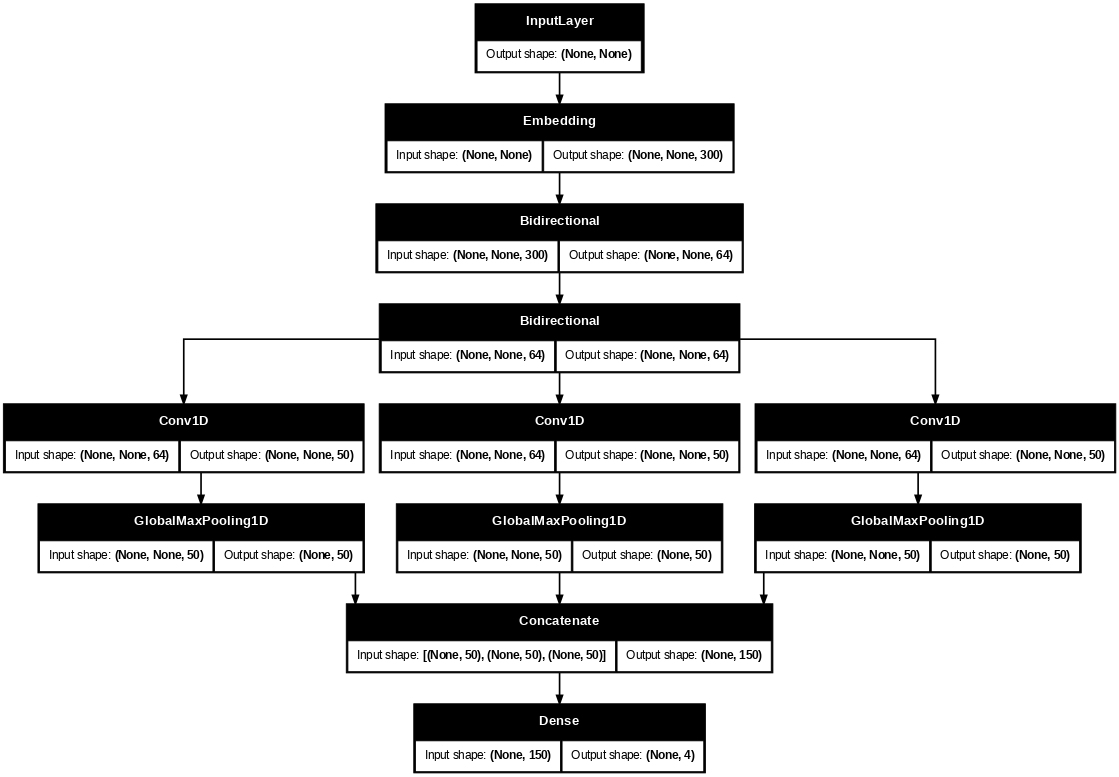

In [ ]:
plotting_model = create_model(lr=0.)
tf.keras.utils.plot_model(plotting_model, show_shapes=True, dpi=60)

In [ ]:
plotting_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 300)      │      6,000,600 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, None, 64)       │         85,248 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, None, 64)       │         24,832 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, None, 50)       │          6,450 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, None, 50)       │          9,650 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, None, 50)       │         12,850 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 50)             │              0 │ conv1d[0][0]           │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 50)             │              0 │ conv1d_1[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 50)             │              0 │ conv1d_2[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 150)            │              0 │ global_max_pooling1d[… │
│                           │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            604 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,140,234 (23.42 MB)

 Trainable params: 139,634 (545.45 KB)

 Non-trainable params: 6,000,600 (22.89 MB)

## Training & Evaluation

In [ ]:
reps = 5
lr = 6e-4
epochs = 10

histories = []
val_accuracy, val_f1score, val_mf1score = [], [], []
test_accuracy, test_f1score, test_mf1score = [], [], []
for _ in range(reps):
  model = create_model(lr)

  history = model.fit(x=train_dataset, validation_data=val_dataset, epochs=epochs)
  histories.append(history)

  _, accuracy, f1score, mf1score = evaluate(model, val_dataset, val_labels)
  val_accuracy.append(accuracy)
  val_f1score.append(f1score)
  val_mf1score.append(mf1score)

  _, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
  test_accuracy.append(accuracy)
  test_f1score.append(f1score)
  test_mf1score.append(mf1score)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.4248 - loss: 1.2534 - val_accuracy: 0.5290 - val_loss: 1.1730
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5828 - loss: 1.0156 - val_accuracy: 0.5554 - val_loss: 1.1104
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6665 - loss: 0.8850 - val_accuracy: 0.5888 - val_loss: 1.0387
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7331 - loss: 0.7437 - val_accuracy: 0.6257 - val_loss: 0.9818
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7988 - loss: 0.6006 - val_accuracy: 0.6485 - val_loss: 0.9290
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8509 - loss: 0.4539 - val_accuracy: 0.6977 - val_loss: 0.8874
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9109 - loss: 0.3102 - val_accuracy: 0.7241 - val_loss: 0.9666
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9530 - loss: 0.1956 - val_accuracy: 0.7118 - v

**Overfitting Analysis**  
The gap between training and validation performance indicates that the model is overfitting the training data. Several factors contribute to this issue:
1. **Insufficient Data**: The relatively small training dataset of 2848 instances is insufficient for the model to learn the intricate nuances of the task, particularly given its inherent complexity.
2. **Task Complexity:** The 'disagree' and 'discuss' classes pose significant challenges due to their subtle distinctions. While 'unrelated' and 'agree' classes can often be identified through simple textual similarity, 'disagree' and 'discuss' require deeper semantic understanding and the ability to detect complex linguistic cues:
   - **Discuss class:** Discussing involves giving more details and different viewpoints.
   - **Disagree class:** Disagreement could involve simple negation terms or more complex negations like changing dates, quantities, or introducing opposing concepts (e.g. Sky is Blue vs. Sky is Black).

3. **Annotation Errors:** Manual inspection has revealed a non-negligible number of misannotations, further complicating the learning process.
4. **Language Challenges:** Arabic, the language of the dataset, presents additional complexities due to its rich morphology and diverse dialects.
5. **Class Imbalance:** The 'unrelated' class significantly outnumbers the other classes. Additionally, the 'disagree' and 'discuss' classes are underrepresented compared to the 'agree' and 'unrelated' classes. The relative lower representations of the 'discuss' and 'disagree' classes across the three sets exacerbates the classification challenge.

![image not found](tab_arastance.png)

**Mitigating Overfitting**  
While regularization techniques and early stopping may have limited effectiveness, addressing the underlying data limitations is crucial:
1. **Data Augmentation:** Explore techniques like back-translation, synonym replacement, and text generation to artificially expand the dataset.
2. **Transfer Learning:** Leverage pre-trained language models to incorporate prior knowledge and improve generalization.
3. **Ensemble Methods:** Combine multiple models to reduce variance and improve overall performance.



### Results

In [ ]:
print("Validation Resutls:")
print("=====================")
print(f"Mean Accuracy: {np.mean(val_accuracy):.3f}")
agree, disagree, discuss, unrelated = np.mean(val_f1score, axis=0)
print("Mean Per Class F1 scores:")
print(f"Agree   : {agree:.3f}")
print(f"Disagree: {disagree:.3f}")
print(f"Discuss : {discuss:.3f}")
print(f"Unrelated: {unrelated:.3f}")
print(f"Mean Macro F1 scores: {np.mean(val_mf1score):.3f}")

Validation Resutls:
Mean Accuracy: 0.740
Mean Per Class F1 scores:
Agree   : 0.712
Disagree: 0.667
Discuss : 0.443
Unrelated: 0.832
Mean Macro F1 scores: 0.663


In [ ]:
print("Testing Resutls:")
print("=====================")
print(f"Mean Accuracy: {np.mean(test_accuracy):.3f}")
agree, disagree, discuss, unrelated = np.mean(test_f1score, axis=0)
print("Mean Per Class F1 scores:")
print(f"Agree   : {agree:.3f}")
print(f"Disagree: {disagree:.3f}")
print(f"Discuss : {discuss:.3f}")
print(f"Unrelated: {unrelated:.3f}")
print(f"Mean Macro F1 scores: {np.mean(test_mf1score):.3f}")

Testing Resutls:
Mean Accuracy: 0.794
Mean Per Class F1 scores:
Agree   : 0.772
Disagree: 0.701
Discuss : 0.459
Unrelated: 0.874
Mean Macro F1 scores: 0.702
